<a href="https://colab.research.google.com/github/talhaanwarch/Plant-Leaf-Disease-Classification/blob/master/model_comparison_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### download data

In [1]:
!wget https://data.mendeley.com/datasets/3f83gxmv57/2/files/53398b67-6f0e-4a67-8384-e2b574b2ebf4/Citrus.zip

--2020-04-13 17:44:20--  https://data.mendeley.com/datasets/3f83gxmv57/2/files/53398b67-6f0e-4a67-8384-e2b574b2ebf4/Citrus.zip
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86, 2606:4700:7::a29f:8256, ...
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/ad404a4d-cedf-4830-8a11-0fc204ce8acb [following]
--2020-04-13 17:44:22--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/ad404a4d-cedf-4830-8a11-0fc204ce8acb
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.57.96
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.57.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66977095 (64M) [

### install efficinetnet model

In [0]:
%%capture
!pip install efficientnet

### unzip donwloaded dataset

In [0]:
%%capture
!unzip /content/Citrus.zip

## import libraries

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt


## data augmentation 

In [0]:
from keras_preprocessing.image import ImageDataGenerator

data_gen= ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=360,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=.1,
    rescale=1/255,
    fill_mode='nearest',
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    validation_split=0.3)

## load data 
load data from directory in generator structure, infact data is loaded while training

In [0]:
img_shape=300
batch_size=16

In [7]:
#load the training data
train_generator = data_gen.flow_from_directory(
    '/content/Citrus/Leaves',
    target_size=(img_shape,img_shape),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)


Found 429 images belonging to 5 classes.


In [8]:
#load the training data
val_suffle=False
val_generator = data_gen.flow_from_directory(
    '/content/Citrus/Leaves',
    target_size=(img_shape,img_shape),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',shuffle=val_suffle)#shuffle should be False in validation
    #https://stackoverflow.com/a/47439789/11170350


Found 180 images belonging to 5 classes.


In [9]:
train_generator.next()[0].shape,train_generator.next()[1].shape

((16, 300, 300, 3), (16, 5))

In [10]:
val_generator.next()[0].shape,val_generator.next()[1].shape

((16, 300, 300, 3), (16, 5))

In [11]:
from sklearn.metrics import roc_auc_score,roc_curve,auc
import seaborn as sns
def plot_multiclass_roc(y_pred, y_test, n_classes,class_label, figsize=(17, 6)):
    
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test.iloc[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i,j in enumerate(class_label):
        print(i,j)
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = {}) for label {}'.format(np.round(roc_auc[i],2),j))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
  


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization,Input,MaxPooling2D,GlobalMaxPooling2D,concatenate
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

## Densenet 121

### no weights

In [0]:
from tensorflow.keras.applications.densenet import DenseNet121
model =DenseNet121(weights = None, include_top=False, input_shape = (img_shape,img_shape,3))


In [0]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
model = Model(inputs=model.input, outputs=predictions)

In [0]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [0]:
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

In [18]:

trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 7,177,285
Trainable params: 7,093,637
Non-trainable params: 83,648


In [19]:
%%time
results = model.fit(train_generator,epochs=25,verbose=0,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              #callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)]
                    )

CPU times: user 10min 13s, sys: 43.4 s, total: 10min 56s
Wall time: 8min 54s


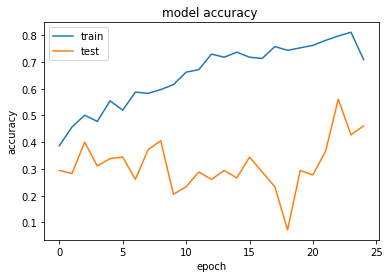

In [20]:

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

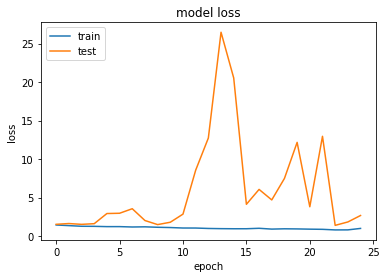

In [21]:

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 4s 370ms/step - loss: 2.8349 - accuracy: 0.4573


[2.834927558898926, 0.4573170840740204]

In [23]:
val_generator.reset()
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 4s 395ms/step - loss: 2.2710 - accuracy: 0.4659


[2.271042585372925, 0.46590909361839294]

In [24]:
val_generator.reset()
y_pred=model.predict(val_generator,steps=val_generator.n/batch_size,verbose=1)

12/11 [================================] - 4s 369ms/step


In [0]:
class_label=list(train_generator.class_indices.keys())


In [0]:
if val_suffle==True:
  per = np.random.permutation(val_generator.n)
  val_generator.index_array = per
  y_true = val_generator.classes[per]
else: 
  y_true = val_generator.classes

0 Black spot
1 Melanose
2 canker
3 greening
4 healthy


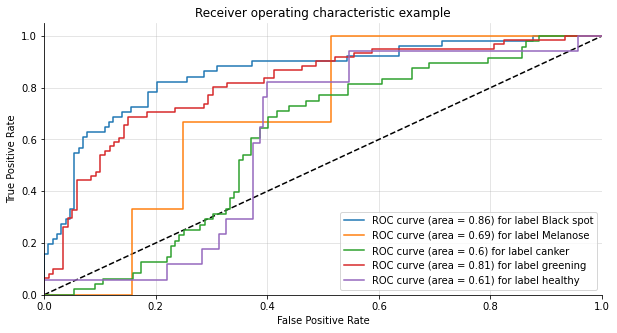

In [27]:
plot_multiclass_roc( y_pred, pd.get_dummies(y_true), n_classes=5,class_label=class_label, figsize=(10, 5))

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [29]:
y_pred.shape,y_true.shape

((180,), (180,))

In [30]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.45
0.24269841269841272


In [31]:
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.76      0.43      0.55        51
    Melanose       0.00      0.00      0.00         3
      canker       0.00      0.00      0.00        48
    greening       0.39      0.95      0.55        61
     healthy       1.00      0.06      0.11        17

    accuracy                           0.45       180
   macro avg       0.43      0.29      0.24       180
weighted avg       0.44      0.45      0.35       180



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Imagenet weights

In [32]:
from tensorflow.keras.applications.densenet import DenseNet121
model =DenseNet121(weights = 'imagenet', include_top=False, input_shape = (img_shape,img_shape,3))


29089792/29084464 [==============================] - 0s 0us/step


In [0]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
model = Model(inputs=model.input, outputs=predictions)

In [0]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [0]:
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

In [37]:

trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 7,177,285
Trainable params: 7,093,637
Non-trainable params: 83,648


In [38]:
%%time
results = model.fit(train_generator,epochs=25,verbose=0,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              #callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)]
                    )

CPU times: user 9min 44s, sys: 40.7 s, total: 10min 25s
Wall time: 8min 20s


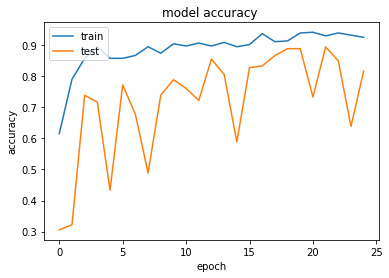

In [39]:

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

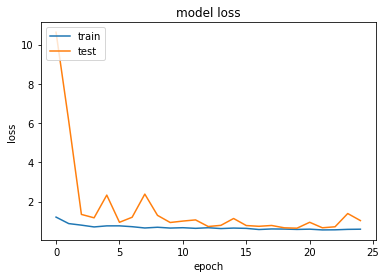

In [40]:

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 4s 353ms/step - loss: 1.0567 - accuracy: 0.8049


[1.0566571950912476, 0.8048780560493469]

In [42]:
val_generator.reset()
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 4s 378ms/step - loss: 0.8612 - accuracy: 0.8182


[0.8612412810325623, 0.8181818127632141]

In [43]:
val_generator.reset()
y_pred=model.predict(val_generator,steps=val_generator.n/batch_size,verbose=1)

12/11 [================================] - 4s 356ms/step


In [0]:
if val_suffle==True:
  per = np.random.permutation(val_generator.n)
  val_generator.index_array = per
  y_true = val_generator.classes[per]
else: 
  y_true = val_generator.classes

0 Black spot
1 Melanose
2 canker
3 greening
4 healthy


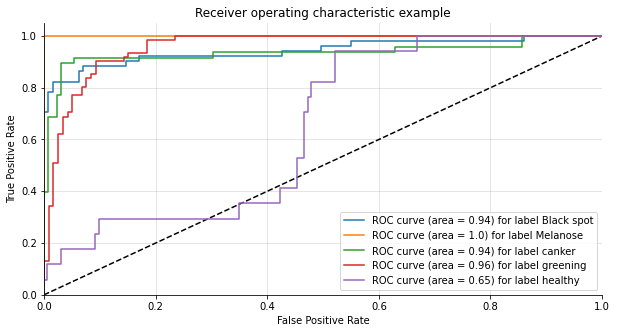

In [45]:
plot_multiclass_roc( y_pred, pd.get_dummies(y_true), n_classes=5,class_label=class_label, figsize=(10, 5))

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [47]:
y_pred.shape,y_true.shape

((180,), (180,))

In [48]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.8222222222222222
0.7211600429645543


In [49]:
class_label=list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.95      0.82      0.88        51
    Melanose       1.00      1.00      1.00         3
      canker       0.91      0.90      0.91        48
    greening       0.70      0.98      0.82        61
     healthy       0.00      0.00      0.00        17

    accuracy                           0.82       180
   macro avg       0.71      0.74      0.72       180
weighted avg       0.77      0.82      0.79       180



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## EfficientNetB3

In [0]:
import efficientnet.tfkeras as efn
model =efn.EfficientNetB3(weights =None, include_top=False, input_shape = (img_shape,img_shape,3))


In [0]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
model = Model(inputs=model.input, outputs=predictions)

In [0]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [0]:
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

In [55]:

trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 10,988,845
Trainable params: 10,901,549
Non-trainable params: 87,296


In [56]:
%%time
results = model.fit(train_generator,epochs=25,verbose=0,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              #callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)]
                    )

CPU times: user 13min 45s, sys: 2min 10s, total: 15min 56s
Wall time: 11min 13s


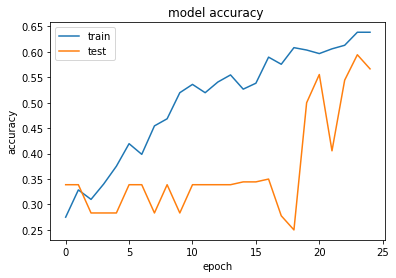

In [57]:

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

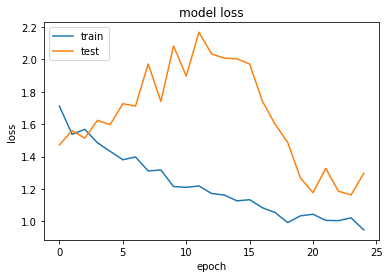

In [58]:

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [59]:
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 4s 368ms/step - loss: 1.2976 - accuracy: 0.6341


[1.2976210117340088, 0.6341463327407837]

In [60]:
val_generator.reset()
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 4s 394ms/step - loss: 1.1619 - accuracy: 0.5966


[1.1618822813034058, 0.5965909361839294]

In [61]:
val_generator.reset()
y_pred=model.predict(val_generator,steps=val_generator.n/batch_size,verbose=1)

12/11 [================================] - 4s 372ms/step


In [0]:
if val_suffle==True:
  per = np.random.permutation(val_generator.n)
  val_generator.index_array = per
  y_true = val_generator.classes[per]
else: 
  y_true = val_generator.classes

0 Black spot
1 Melanose
2 canker
3 greening
4 healthy


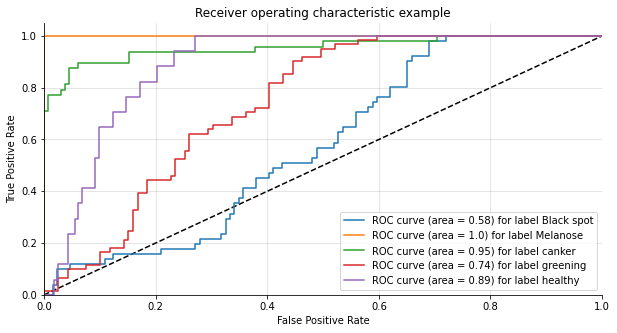

In [63]:
plot_multiclass_roc( y_pred, pd.get_dummies(y_true), n_classes=5,class_label=class_label, figsize=(10, 5))

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [65]:
y_pred.shape,y_true.shape

((180,), (180,))

In [66]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.5722222222222222
0.4241260198916086


In [67]:
class_label=list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.57      0.08      0.14        51
    Melanose       1.00      0.33      0.50         3
      canker       0.95      0.77      0.85        48
    greening       0.46      1.00      0.63        61
     healthy       0.00      0.00      0.00        17

    accuracy                           0.57       180
   macro avg       0.60      0.44      0.42       180
weighted avg       0.59      0.57      0.49       180



### image net weights

In [68]:
import efficientnet.tfkeras as efn
model =efn.EfficientNetB3(weights ='imagenet', include_top=False, input_shape = (img_shape,img_shape,3))


44113920/44107200 [==============================] - 1s 0us/step


In [0]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
x = Dense(64, activation="relu")(x)
predictions = Dense(5, activation="softmax")(x)

In [0]:
model = Model(inputs=model.input, outputs=predictions)

In [0]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

In [0]:
model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

In [73]:

trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 10,988,845
Trainable params: 10,901,549
Non-trainable params: 87,296


In [74]:
%%time
results = model.fit(train_generator,epochs=25,verbose=0,
                              steps_per_epoch=train_generator.n/batch_size,
                              validation_data=val_generator,
                             validation_steps=val_generator.n/batch_size,
                              #callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=2, min_lr=0.000001)]
                    )

CPU times: user 13min 35s, sys: 2min 2s, total: 15min 38s
Wall time: 11min 7s


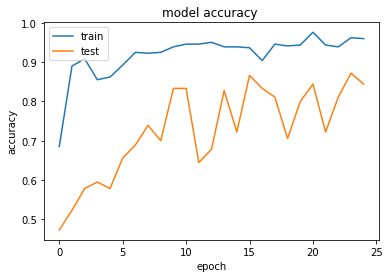

In [75]:

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy ')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

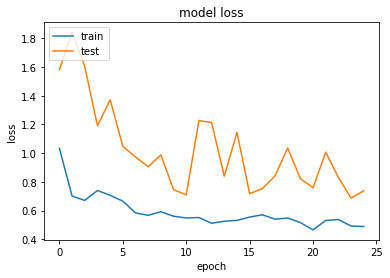

In [76]:

plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [77]:
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 4s 374ms/step - loss: 0.7730 - accuracy: 0.8415


[0.7729955315589905, 0.8414633870124817]

In [78]:
val_generator.reset()
model.evaluate(val_generator,steps=val_generator.n//batch_size)

11/11 [==============================] - 4s 398ms/step - loss: 0.8292 - accuracy: 0.8125


[0.8292270302772522, 0.8125]

In [79]:
val_generator.reset()
y_pred=model.predict(val_generator,steps=val_generator.n/batch_size,verbose=1)

12/11 [================================] - 4s 368ms/step


In [0]:
class_label=list(train_generator.class_indices.keys())


In [0]:
if val_suffle==True:
  per = np.random.permutation(val_generator.n)
  val_generator.index_array = per
  y_true = val_generator.classes[per]
else: 
  y_true = val_generator.classes

0 Black spot
1 Melanose
2 canker
3 greening
4 healthy


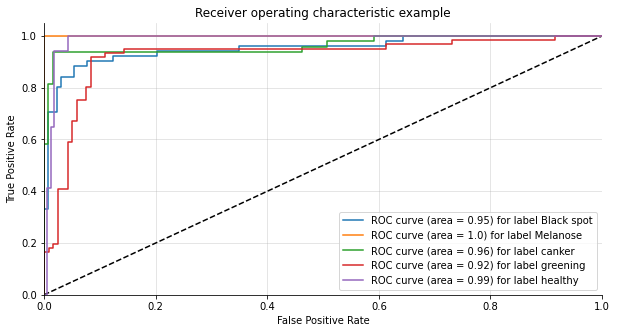

In [82]:
plot_multiclass_roc( y_pred, pd.get_dummies(y_true), n_classes=5,class_label=class_label, figsize=(10, 5))

In [0]:
y_pred=np.argmax(y_pred, axis=1)

In [84]:
y_pred.shape,y_true.shape

((180,), (180,))

In [85]:
from sklearn.metrics import classification_report,accuracy_score,f1_score
print(accuracy_score(y_true,y_pred))
print(f1_score(y_true,y_pred,average='macro'))

0.8277777777777777
0.8599324324324324


In [86]:
print(classification_report(y_true, y_pred,target_names=class_label))#

              precision    recall  f1-score   support

  Black spot       0.77      0.90      0.83        51
    Melanose       1.00      1.00      1.00         3
      canker       0.94      0.94      0.94        48
    greening       0.86      0.62      0.72        61
     healthy       0.68      1.00      0.81        17

    accuracy                           0.83       180
   macro avg       0.85      0.89      0.86       180
weighted avg       0.84      0.83      0.82       180

